## Convert the census tract data to a geopandas dataframe

We've downloaded the 2010 census tract shapefiles data. Here is a link to what the columns mean: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2010.html#list-tab-790442341

In [94]:
import zipfile
import os, shutil
from shapely import MultiPolygon, Polygon, wkt, intersection
import geopandas as gpd
import matplotlib.pyplot as plt

In [95]:
def load_tiger_shapefile(zip_path):
    # Unzip the TIGER/Line Shapefile if it's in a .zip format
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        extract_dir = zip_path.rstrip('.zip')
        zip_ref.extractall(extract_dir)

    # Find the main shapefile (the one with .shp extension)
    shp_file = next((f for f in os.listdir(extract_dir) if f.endswith('.shp')), None)
    if not shp_file:
        raise FileNotFoundError("No .shp file found in the extracted contents")

    # Load shapefile into a GeoDataFrame
    gdf = gpd.read_file(os.path.join(extract_dir, shp_file))
    
    # Clean up extracted files if desired
    shutil.rmtree(extract_dir)

    return gdf

zip_path = './chc/tl_2010_17_tract10.zip' # path to the TIGER/Line Shapefile ZIP file
gdf = load_tiger_shapefile(zip_path)
gdf = gdf.loc[gdf['COUNTYFP10'] == '031'] # 031 is the 2010 FIPS code for Cook County

In [96]:
gdf

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
1310,17,031,840300,17031840300,8403,Census Tract 8403,G5020,S,831224,0,+41.8320943,-087.6818822,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
1311,17,031,840200,17031840200,8402,Census Tract 8402,G5020,S,831087,0,+41.8445748,-087.6491915,"POLYGON ((-87.64633 41.84009, -87.64632 41.839..."
1312,17,031,841100,17031841100,8411,Census Tract 8411,G5020,S,1143247,0,+41.8510058,-087.6350978,"POLYGON ((-87.62935 41.8528, -87.62934 41.8525..."
1313,17,031,841200,17031841200,8412,Census Tract 8412,G5020,S,625405,0,+41.8555618,-087.6833420,"POLYGON ((-87.68814 41.85569, -87.68816 41.856..."
1314,17,031,838200,17031838200,8382,Census Tract 8382,G5020,S,1157564,0,+41.8704157,-087.6750794,"POLYGON ((-87.66782 41.87418, -87.66768 41.874..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,17,031,823604,17031823604,8236.04,Census Tract 8236.04,G5020,S,3563788,0,+41.6578553,-087.7884283,"POLYGON ((-87.78982 41.64633, -87.79053 41.646..."
2706,17,031,825501,17031825501,8255.01,Census Tract 8255.01,G5020,S,6026982,0,+41.5784583,-087.7170864,"POLYGON ((-87.702 41.5717, -87.70213 41.5717, ..."
2707,17,031,825302,17031825302,8253.02,Census Tract 8253.02,G5020,S,5837555,0,+41.5811669,-087.7574057,"POLYGON ((-87.75998 41.58827, -87.7598 41.5882..."
2708,17,031,823602,17031823602,8236.02,Census Tract 8236.02,G5020,S,4847250,72892,+41.6496157,-087.7616774,"POLYGON ((-87.77216 41.6466, -87.77227 41.6466..."


<Axes: >

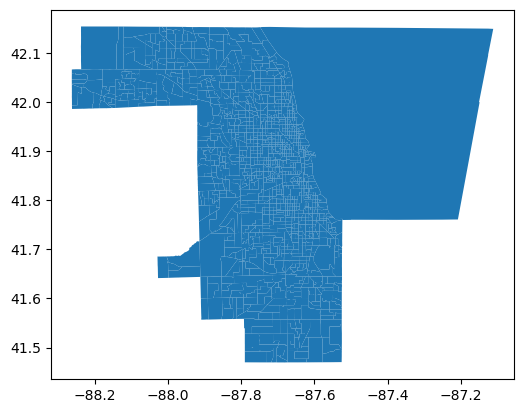

In [97]:
gdf.plot()

## Set up the census data

Following the instructions on https://pypi.org/project/census/, we obtained a Census API key.

In [ ]:
#!pip install census
#!pip install us

In [98]:
from census import Census
from us import states
import pandas as pd

In [99]:
c = Census("648aad200a68fa1e982b77c8ed1c87c14f777a2a")

In [100]:
def get_census_data(census_fields={'NAME': 'name'}):
    tract_data = c.acs5.get(tuple(census_fields.keys()), {'for': 'tract:*', 'in': 'state:17 county:031'})
    
    # convert the tract data to a pandas DataFrame
    df = pd.DataFrame(tract_data)

    # rename the columns of df for readability
    df.rename(columns=census_fields, inplace=True)

    return df


In [101]:
census_fields = {'NAME': 'name',
                'B02001_001E': 'total_population',
                'B19013_001E': 'median_household_income',
                'B02001_002E': 'white_alone',
                'B02001_003E': 'black_alone',
                'B02001_004E': 'indigenous_alone',
                'B02001_005E': 'asian_alone',
                'B02001_006E': 'pacific_islander_alone',
                'B02001_007E': 'other_alone',
                'B02001_008E': 'multiracial'}
census_data = get_census_data(census_fields)

In [102]:
def clean_census_data(census_data):
    # Remove census tracts with 0 population
    census_data = census_data[census_data['total_population'] > 0.0]
    return census_data

cleaned_census_data = clean_census_data(census_data)

In [103]:
cleaned_census_data

,name,total_population,median_household_income,white_alone,black_alone,indigenous_alone,asian_alone,pacific_islander_alone,other_alone,multiracial,state,county,tract
0,Census Tract 101; Cook County; Illinois,4284.0,68196.0,1915.0,1376.0,0.0,94.0,0.0,278.0,621.0,17,031,010100
1,Census Tract 102.01; Cook County; Illinois,8210.0,61071.0,2087.0,3009.0,41.0,298.0,0.0,838.0,1937.0,17,031,010201
2,Census Tract 102.02; Cook County; Illinois,2865.0,58698.0,892.0,945.0,86.0,312.0,0.0,353.0,277.0,17,031,010202
3,Census Tract 103; Cook County; Illinois,6237.0,68336.0,3343.0,1473.0,76.0,338.0,0.0,704.0,303.0,17,031,010300
4,Census Tract 104; Cook County; Illinois,4473.0,48630.0,3578.0,354.0,0.0,213.0,0.0,71.0,257.0,17,031,010400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,Census Tract 8437; Cook County; Illinois,2453.0,191384.0,1749.0,70.0,0.0,129.0,0.0,32.0,473.0,17,031,843700
1325,Census Tract 8438; Cook County; Illinois,1479.0,32095.0,624.0,613.0,0.0,79.0,0.0,7.0,156.0,17,031,843800
1326,Census Tract 8439; Cook County; Illinois,3700.0,56926.0,260.0,3190.0,29.0,50.0,0.0,98.0,73.0,17,031,843900
1327,Census Tract 8446; Cook County; Illinois,2275.0,54565.0,106.0,2050.0,0.0,0.0,24.0,15.0,80.0,17,031,844600


### Heat Maps
We first combine `gdf` with `cleaned_census_data`.

In [109]:
geo_census_data = gdf.join(cleaned_census_data.set_index('tract'), on='TRACTCE10')

<Axes: >

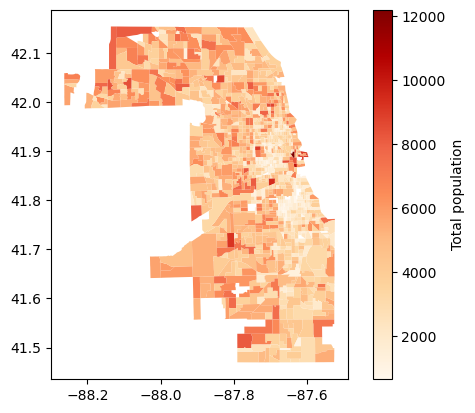

In [110]:
geo_census_data.plot(column='total_population', cmap='OrRd', legend=True,
                     legend_kwds={"label": "Total population"})